In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

读取数据，提取特征和目标变量

In [2]:
df = pd.read_csv('insurance.csv')
features = df[['age', 'bmi', 'children', 'smoker', 'region']]
target = df['charges']


In [3]:
features = features.copy()#复制一个数据副本

label_encoder = LabelEncoder()
features['smoker'] = label_encoder.fit_transform(features['smoker'])
features = pd.get_dummies(features, columns=['region'])

In [4]:
scaler = StandardScaler()
features[['age', 'bmi', 'children']] = scaler.fit_transform(features[['age', 'bmi', 'children']])

features = features.astype('float32')
target = target.astype('float32')

In [5]:
# 切分数据集
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# 将数据转化为pytorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [7]:
# 定义模型架构
class FeedForwardModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.8):
        super(FeedForwardModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [8]:
# 设置模型参数
input_size = features.shape[1]
hidden_size1 = 64  
hidden_size2 = 32 
output_size = 1
dropout_rate = 0.8  

model = FeedForwardModel(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)

num_epochs = 1000  
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 257100816.0000, Validation Loss: 230109760.0000
Epoch [200/1000], Train Loss: 185874784.0000, Validation Loss: 147015984.0000
Epoch [300/1000], Train Loss: 184068704.0000, Validation Loss: 145290752.0000
Epoch [400/1000], Train Loss: 182564368.0000, Validation Loss: 144862176.0000
Epoch [500/1000], Train Loss: 182608560.0000, Validation Loss: 144393888.0000
Epoch [600/1000], Train Loss: 182412832.0000, Validation Loss: 144275488.0000
Epoch [700/1000], Train Loss: 180971296.0000, Validation Loss: 144161664.0000
Epoch [800/1000], Train Loss: 184223136.0000, Validation Loss: 144565600.0000
Epoch [900/1000], Train Loss: 183959936.0000, Validation Loss: 143823200.0000
Epoch [1000/1000], Train Loss: 180918528.0000, Validation Loss: 144624640.0000


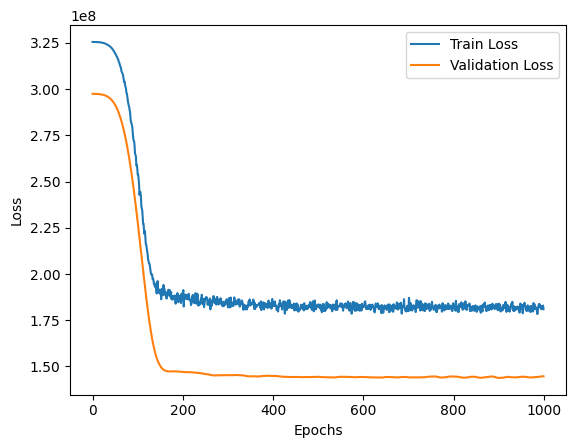

测试集的平均绝对误差: 8565.2686


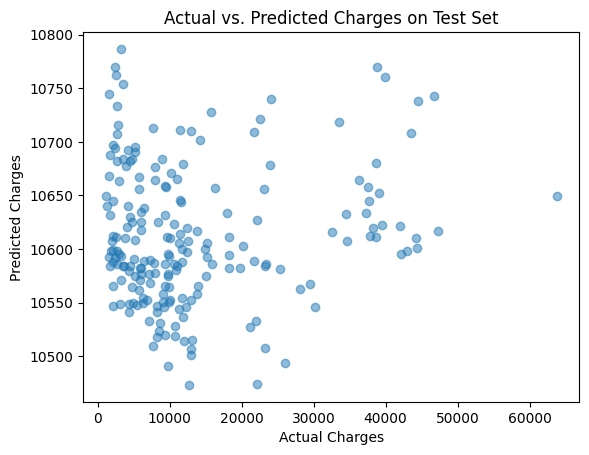

In [9]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'测试集的平均绝对误差: {mae_test:.4f}')


plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [10]:
# 设置模型参数
input_size = features.shape[1]
hidden_size1 = 64  
hidden_size2 = 32 
output_size = 1
dropout_rate = 0.8  

model = FeedForwardModel(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000  
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 325298272.0000, Validation Loss: 297256672.0000
Epoch [200/1000], Train Loss: 323592672.0000, Validation Loss: 295658304.0000
Epoch [300/1000], Train Loss: 318093280.0000, Validation Loss: 290393952.0000
Epoch [400/1000], Train Loss: 306502048.0000, Validation Loss: 279420736.0000
Epoch [500/1000], Train Loss: 288070496.0000, Validation Loss: 262117264.0000
Epoch [600/1000], Train Loss: 264958448.0000, Validation Loss: 238796032.0000
Epoch [700/1000], Train Loss: 240899888.0000, Validation Loss: 212886240.0000
Epoch [800/1000], Train Loss: 219354112.0000, Validation Loss: 189354768.0000
Epoch [900/1000], Train Loss: 206061648.0000, Validation Loss: 172036848.0000
Epoch [1000/1000], Train Loss: 198683344.0000, Validation Loss: 161181136.0000


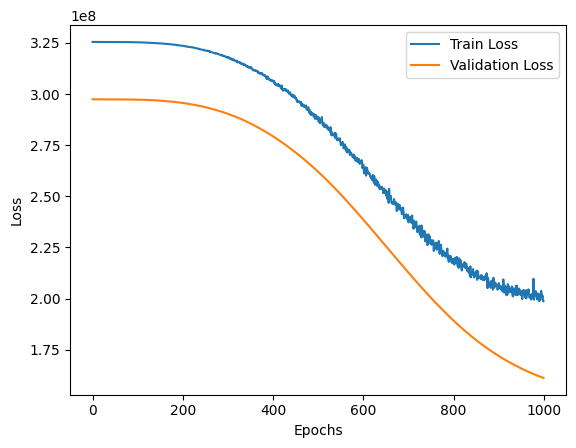

测试集的平均绝对误差: 7966.0845


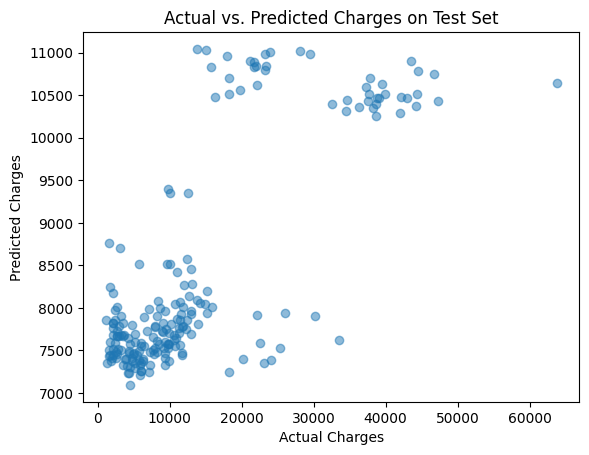

In [11]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'测试集的平均绝对误差: {mae_test:.4f}')


plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [14]:
# 定义线性回归模型架构
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# 设置输入大小和输出大小
input_size = features.shape[1]
output_size = 1

# 实例化模型
model = LinearRegressionModel(input_size, output_size)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0006)

In [15]:
# 训练循环
num_epochs = 1000  # 根据需要调整
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 前向传播和训练损失
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 278087392.0000, Validation Loss: 253312800.0000
Epoch [200/1000], Train Loss: 242999696.0000, Validation Loss: 221380992.0000
Epoch [300/1000], Train Loss: 217319776.0000, Validation Loss: 198313008.0000
Epoch [400/1000], Train Loss: 198522688.0000, Validation Loss: 181688640.0000
Epoch [500/1000], Train Loss: 184761248.0000, Validation Loss: 169742880.0000
Epoch [600/1000], Train Loss: 174684336.0000, Validation Loss: 161189376.0000
Epoch [700/1000], Train Loss: 167303408.0000, Validation Loss: 155091264.0000
Epoch [800/1000], Train Loss: 161895280.0000, Validation Loss: 150766736.0000
Epoch [900/1000], Train Loss: 157930880.0000, Validation Loss: 147720112.0000
Epoch [1000/1000], Train Loss: 155023120.0000, Validation Loss: 145591600.0000


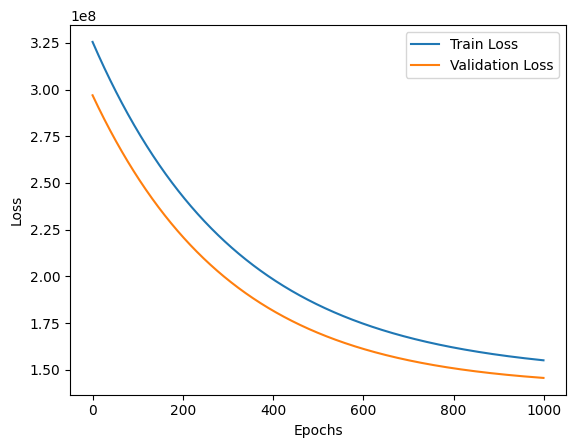

测试集的平均绝对误差: 8194.1465


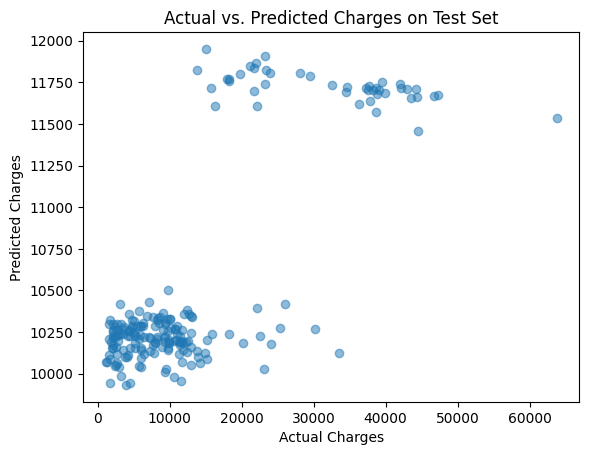

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'测试集的平均绝对误差: {mae_test:.4f}')

# 可视化结果
plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [19]:
# 定义逻辑回归模型架构
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

# 设置输入大小和输出大小
input_size = features.shape[1]
output_size = 1  # 逻辑回归的输出大小通常为1，表示二分类的概率

# 实例化模型
model = LogisticRegressionModel(input_size, output_size)


In [20]:
# 训练循环
num_epochs = 1000  # 根据需要调整
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 前向传播和训练损失
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [200/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [300/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [400/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [500/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [600/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [700/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [800/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [900/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000
Epoch [1000/1000], Train Loss: 325455872.0000, Validation Loss: 297404512.0000


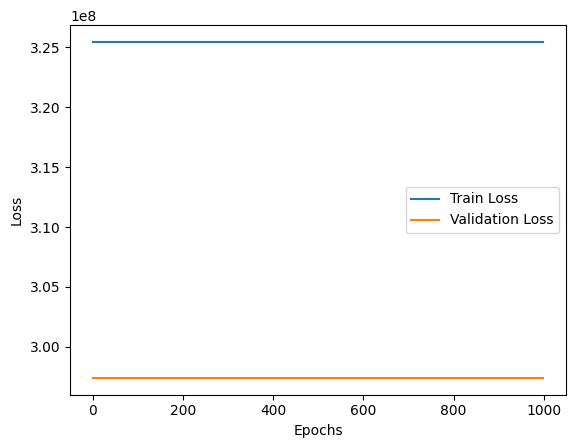

测试集的平均绝对误差: 13530.1328


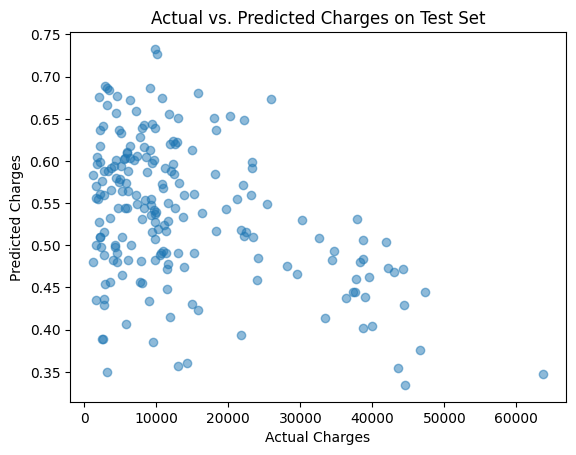

In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'测试集的平均绝对误差: {mae_test:.4f}')

# 可视化结果
plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


In [23]:

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [24]:
# 定义MLP模型架构
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# 设置输入大小、隐藏层大小和输出大小
input_size = features.shape[1]
hidden_size1 = 64  # 根据需要调整
hidden_size2 = 32  # 根据需要调整
output_size = 1    # 根据需要调整

# 实例化模型
model = MLPModel(input_size, hidden_size1, hidden_size2, output_size)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# 训练循环
num_epochs = 1000  # 根据需要调整
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 前向传播和训练损失
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 验证损失
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # 保存损失以供绘图
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # 打印训练信息
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')



c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([936])) that is different to the input size (torch.Size([936, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\15017\.conda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([201])) that is different to the input size (torch.Size([201, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 325003040.0000, Validation Loss: 296975104.0000
Epoch [200/1000], Train Loss: 321353408.0000, Validation Loss: 293583008.0000
Epoch [300/1000], Train Loss: 310405792.0000, Validation Loss: 283485408.0000
Epoch [400/1000], Train Loss: 289600672.0000, Validation Loss: 264408512.0000
Epoch [500/1000], Train Loss: 259576256.0000, Validation Loss: 237080144.0000
Epoch [600/1000], Train Loss: 224832944.0000, Validation Loss: 205810304.0000
Epoch [700/1000], Train Loss: 192579136.0000, Validation Loss: 177346976.0000
Epoch [800/1000], Train Loss: 169312016.0000, Validation Loss: 157583344.0000
Epoch [900/1000], Train Loss: 156837024.0000, Validation Loss: 147821088.0000
Epoch [1000/1000], Train Loss: 151876704.0000, Validation Loss: 144619760.0000


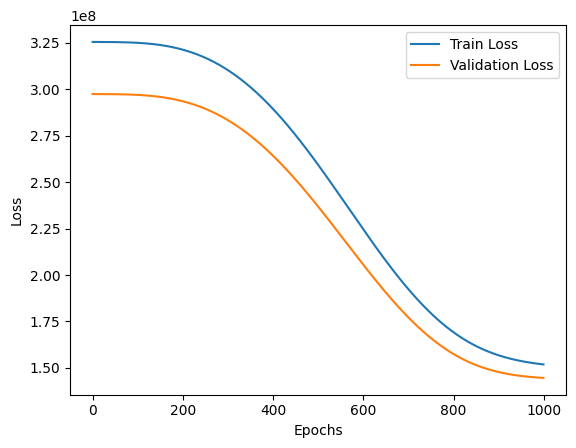

测试集的平均绝对误差: 7744.0425


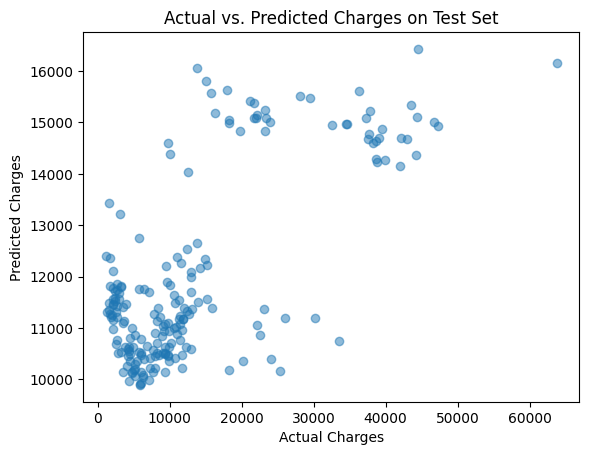

In [26]:
# 绘制训练和验证损失
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 在测试集上评估模型
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    mae_test = mean_absolute_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f'测试集的平均绝对误差: {mae_test:.4f}')

# 可视化结果
plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), alpha=0.5)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs. Predicted Charges on Test Set')
plt.show()

In [32]:
def predict_price(input_data):
    # 确保模型处于评估模式
    model.eval()

    # 将输入数据转换为张量
    input_tensor = torch.tensor(input_data, dtype=torch.float32)

    # 使用模型进行预测
    with torch.no_grad():
        prediction = model(input_tensor)

    # 返回预测的价格
    return prediction.item()


In [36]:
features = np.array([56.   ,       0.      ,   33.04996931 , 3.  ,        0.  ,        1.        ,0,0])

In [37]:
price = predict_price(features)
print(f"预测的价格是: {price}")


预测的价格是: 184955.15625
